In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Setup dan Data Loading

In [11]:
# Memuat Dataset
try:
    df = pd.read_excel('Online Retail.xlsx') # Untuk read_excel format .xlsx files
    print("Data berhasil dimuat. Lima baris pertama:")
    print(df.head())
    print("\nInformasi umum dataset:")
    df.info()
except FileNotFoundError:
    print("ERROR: File 'Online Retail.xlsx' tidak ditemukan. Pastikan file sudah diunggah.")

Data berhasil dimuat. Lima baris pertama:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

Informasi umum dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column 

Pembersihan Data Tahap 1 - Menangani Missing Values

In [12]:
# Cek Missing Values
print("Jumlah baris sebelum penanganan missing values:", len(df))
missing_count = df.isnull().sum()
print("\nMissing values per kolom:\n", missing_count)

# Menghapus baris dengan CustomerID yang hilang
# Menggunakan .copy() untuk memastikan bekerja dengan DataFrame baru
# Ini akan menghilangkan SettingWithCopyWarning.
df_clean = df.dropna(subset=['CustomerID']).copy()

# Konversi CustomerID ke integer
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

print("\nJumlah baris setelah menghapus missing CustomerID:", len(df_clean))
print("Missing values pada CustomerID saat ini:", df_clean['CustomerID'].isnull().sum())
df_clean.info()

Jumlah baris sebelum penanganan missing values: 541909

Missing values per kolom:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Jumlah baris setelah menghapus missing CustomerID: 406829
Missing values pada CustomerID saat ini: 0
<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int64         
 7   Country      406829 non-null  object        
dtypes: datetime64[ns

Pembersihan Data Tahap 2 - Filter Transaksi & Format Data

In [13]:
# 1. Menghapus Transaksi Pengembalian (Return)
# Transaksi pengembalian diidentifikasi dengan InvoiceNo yang diawali 'C'
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]

# 2. Memastikan Tipe Data Numerik Positif dan Format Tanggal
# Quantity dan UnitPrice harus positif
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# Mengubah InvoiceDate menjadi tipe datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Menghitung Total Harga (Monetary)
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

print("Jumlah baris setelah filter transaksi pengembalian dan nilai positif:", len(df_clean))
print("\nDistribusi Quantity dan UnitPrice setelah filtering:")
print(df_clean[['Quantity', 'UnitPrice']].describe())

Jumlah baris setelah filter transaksi pengembalian dan nilai positif: 397884

Distribusi Quantity dan UnitPrice setelah filtering:
            Quantity      UnitPrice
count  397884.000000  397884.000000
mean       12.988238       3.116488
std       179.331775      22.097877
min         1.000000       0.001000
25%         2.000000       1.250000
50%         6.000000       1.950000
75%        12.000000       3.750000
max     80995.000000    8142.750000


Pembersihan Data Tahap 3 - Penanganan Outliers (IQR Method)

In [14]:
def remove_outliers_iqr(df, column):
    """Menghapus outliers menggunakan metode IQR."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Hanya mengambil nilai di dalam batas IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    print(f"Outliers pada kolom '{column}' dihapus. Baris terhapus: {len(df) - len(df_filtered)}")
    return df_filtered

# Menghapus outliers pada Quantity
df_processed = remove_outliers_iqr(df_clean, 'Quantity')

# Menghapus outliers pada UnitPrice
df_processed = remove_outliers_iqr(df_processed, 'UnitPrice')

print("\nJumlah baris akhir setelah penanganan outliers:", len(df_processed))
print("\nStatistik deskriptif akhir (Dataframe Bersih):")
print(df_processed[['Quantity', 'UnitPrice', 'TotalPrice']].describe())

Outliers pada kolom 'Quantity' dihapus. Baris terhapus: 25647
Outliers pada kolom 'UnitPrice' dihapus. Baris terhapus: 34086

Jumlah baris akhir setelah penanganan outliers: 338151

Statistik deskriptif akhir (Dataframe Bersih):
            Quantity      UnitPrice     TotalPrice
count  338151.000000  338151.000000  338151.000000
mean        7.476917       2.192017      12.771994
std         6.770795       1.544770      13.177003
min         1.000000       0.001000       0.001000
25%         2.000000       1.250000       3.800000
50%         6.000000       1.650000      10.080000
75%        12.000000       2.950000      17.400000
max        27.000000       7.500000     178.800000


Exploratory Data Analysis (EDA) Awal

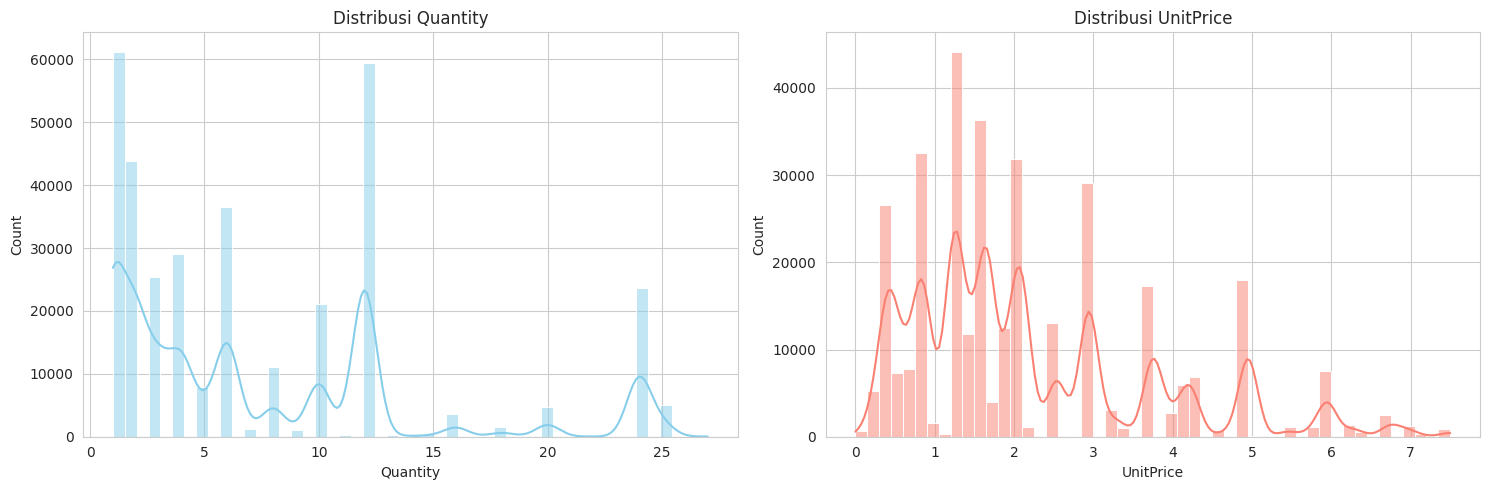

/tmp/ipython-input-225818444.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')


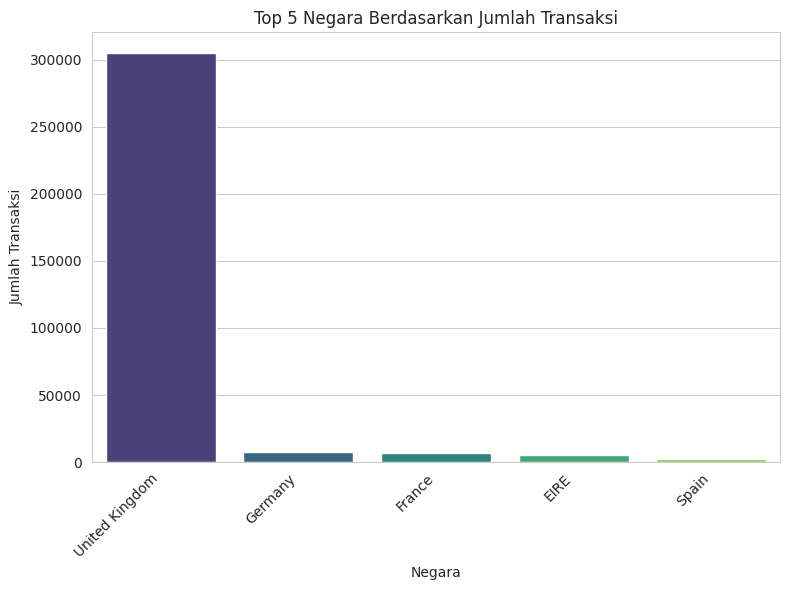

In [15]:
sns.set_style("whitegrid")

# Analisis Distribusi Kunci
plt.figure(figsize=(15, 5))

# Distribusi Quantity
plt.subplot(1, 2, 1)
sns.histplot(df_processed['Quantity'], bins=50, kde=True, color='skyblue')
plt.title('Distribusi Quantity')
plt.xlabel('Quantity')

# Distribusi UnitPrice
plt.subplot(1, 2, 2)
sns.histplot(df_processed['UnitPrice'], bins=50, kde=True, color='salmon')
plt.title('Distribusi UnitPrice')
plt.xlabel('UnitPrice')

plt.tight_layout()
plt.show()

# Analisis Geografis (Top 5 Negara Pelanggan)
country_counts = df_processed['Country'].value_counts().head(5)

plt.figure(figsize=(8, 6))
sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')
plt.title('Top 5 Negara Berdasarkan Jumlah Transaksi')
plt.xlabel('Negara')
plt.ylabel('Jumlah Transaksi')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Hasil Kerja Sprint 1: Dataframe yang bersih dan siap untuk Feature Engineering
df_clean_ready = df_processed.copy()

Export Data

In [17]:
# buat nama file dataset yang di eksport
output_file_name = 'Online_Retail_Clean.csv'

# index=False agar kolom indeks Pandas tidak ikut tersimpan di CSV
df_clean_ready.to_csv(output_file_name, index=False)

print(f"Dataframe berhasil diekspor ke file: {output_file_name}")
print("File siap diunduh dan digunakan untuk tahap Feature Engineering (Sprint 2).")

Dataframe berhasil diekspor ke file: Online_Retail_Clean.csv
File siap diunduh dan digunakan untuk tahap Feature Engineering (Sprint 2).
